<a href="https://colab.research.google.com/github/Aithu-Snehith/End-to-End-Learning-of-Communications-Systems-Without-a-Channel-Model/blob/master/trail_tx_rx_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import *
from sklearn import preprocessing
import tensorflow.keras.backend as K
from sklearn.metrics import mean_squared_error

In [0]:
msg_total = 8
channel = 4
epochs = 5000
Pert_variance = 1e-4
batch_size = 1024

In [0]:
def perturbation(x):
    w = K.random_normal(shape = (channel,2),
    mean=0.0,stddev=Pert_variance**0.5,dtype=None,seed=None)
    xp = ((1-Pert_variance)**0.5)*x + w
#     policy = -K.sum(w*w)
#     print(w_normed.shape)
    return xp

def loss_tx(y_true, y_pred):
    return -y_true*y_pred

def get_policy(inp):
  xp = inp[0]
  x = inp[1]
  w = xp - ((1-Pert_variance)**0.5)*x
  policy = -K.sum(w*w)
  return policy

In [4]:
tx_inp = Input((1,))
embbedings_layer = Dense(msg_total, activation = 'relu')(tx_inp)
layer_dense = Dense(2*channel, activation = 'relu')(embbedings_layer)
to_complex = Reshape((channel,2))(layer_dense)
x = Lambda(lambda x: keras.backend.l2_normalize(x))(to_complex)
xp = Lambda(perturbation)(to_complex)
policy = Lambda(get_policy)([xp,x])

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
model_policy = keras.models.Model(inputs=tx_inp, outputs=policy)
model_tx = keras.models.Model(inputs=tx_inp, outputs=xp)

model_policy.compile(loss=loss_tx, optimizer='sgd')
print(model_policy.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            16          input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            72          dense[0][0]                      
__________________________________________________________________________________________________
reshape (Reshape)               (None, 4, 2)         0           dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [6]:
rx_inp = Input((channel,2))
to_flat = Reshape((2*channel,))(rx_inp)
fc = Dense(msg_total, activation = 'relu')(to_flat)
softmax = Dense(msg_total, activation = 'softmax')(fc)

model_rx = keras.models.Model(inputs=rx_inp, outputs=softmax)

model_rx.compile(loss='mse', optimizer='sgd')
print(model_rx.summary())

Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4, 2)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
loss_tx = []
loss_rx = []
for epoch in range(epochs):
  raw_input = np.random.randint(0,8,(batch_size))
  label = np.zeros((batch_size, 8))
  label[np.arange(batch_size), raw_input] = 1
  tx_input = raw_input/8.0
  xp = model_tx.predict(tx_input)
  y = xp + np.random.normal(0,1,(batch_size, channel,2))
  pred = model_rx.predict(y)
  loss = np.sum(np.square(label - pred), axis = 1)
  print('epoch: ', epoch)
  history_tx = model_policy.fit(tx_input, loss, batch_size=batch_size, epochs=1, verbose=1)
  loss_tx.append(history_tx.history['loss'][0])
  history_rx = model_rx.fit(xp, label, batch_size=batch_size, epochs=1, verbose=1)
  loss_rx.append(history_rx.history['loss'][0])

epoch:  0
Instructions for updating:
Use tf.cast instead.
1024/1024 [==============================] - 0s 111us/sample - loss: 0.1093
epoch:  1
1024/1024 [==============================] - 0s 6us/sample - loss: 0.1094
epoch:  2
1024/1024 [==============================] - 0s 5us/sample - loss: 0.1094
epoch:  3
1024/1024 [==============================] - 0s 3us/sample - loss: 0.1094
epoch:  4
1024/1024 [==============================] - 0s 3us/sample - loss: 0.1094
epoch:  5
1024/1024 [==============================] - 0s 2us/sample - loss: 0.1094
epoch:  6
1024/1024 [==============================] - 0s 3us/sample - loss: 0.1094
epoch:  7
1024/1024 [==============================] - 0s 7us/sample - loss: 0.1094
epoch:  8
1024/1024 [==============================] - 0s 3us/sample - loss: 0.1094
epoch:  9
1024/1024 [==============================] - 0s 3us/sample - loss: 0.1094
epoch:  10
1024/1024 [==============================] - 0s 7us/sample - loss: 0.1094
epoch:  11
1024/1024 [===

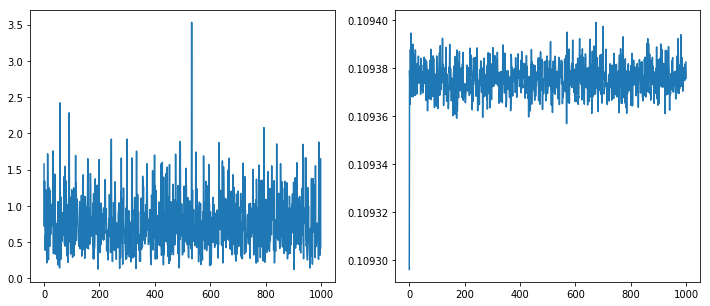

In [8]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(loss_tx)
plt.subplot(1,2,2)
plt.plot(loss_rx)
plt.show()

In [9]:
#testing
batch_size = 25
raw_input = np.random.randint(0,8,(batch_size))
print(raw_input)
label = np.zeros((batch_size, 8))
label[np.arange(batch_size), raw_input] = 1
tx_input = raw_input/8.0
xp = model_tx.predict(tx_input)
y = xp + np.random.normal(0,1,(batch_size, channel,2))
pred = model_rx.predict(y)
pred_int = np.argmax(pred, axis = 1)
print(pred_int)

[6 5 1 0 0 5 7 5 3 5 6 5 7 4 1 7 5 2 7 6 7 2 2 4 0]
[2 2 5 5 6 2 2 5 6 5 2 0 4 0 2 2 2 0 2 2 0 6 2 2 6]
